In [55]:
import pandas as pd
import numpy as np

# File paths
path = "/home/hp/Downloads/"
train_path = path + "sat.trn"
test_path  = path + "sat.tst"

# Define column names: 36 features + 1 target
col_names = [f"band_{i+1}" for i in range(36)] + ["class"]

# Load both datasets
train_df = pd.read_csv(train_path, sep=r"\s+", header=None, names=col_names)
test_df  = pd.read_csv(test_path,  sep=r"\s+", header=None, names=col_names)

# Combine both into one complete dataset
landsat_full = pd.concat([train_df, test_df], ignore_index=True)

# Separate features and target
X = landsat_full.drop(columns=["class"])
y = landsat_full["class"].astype(int)

print("Dataset loaded successfully!")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique class labels:", np.sort(y.unique()))


Dataset loaded successfully!
X shape: (6435, 36)
y shape: (6435,)
Unique class labels: [1 2 3 4 5 7]


### Correction on Class Labels

According to the official `sat.doc` file from the UCI Landsat (Statlog) dataset:

| Class | Description |
|:------:|:-------------|
| 1 | Red soil |
| 2 | Cotton crop |
| 3 | Grey soil |
| 4 | Damp grey soil |
| 5 | Soil with vegetation stubble |
| 6 | Mixture class (all types present) — *no samples present* |
| 7 | Very damp grey soil |

Hence, the dataset legitimately contains **classes 1–5 and 7** (total 6 usable classes).  
Class **6** ("all types present") has **no data entries**, so no explicit removal is needed.


In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split (70–30, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (4504, 36)
Test shape: (1931, 36)


In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Define models
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy (Prior)": DummyClassifier(strategy="prior"),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVC": SVC(probability=True, random_state=42)
}

# Train all models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"Trained: {name}")


Trained: KNN
Trained: Decision Tree
Trained: Dummy (Prior)
Trained: Logistic Regression
Trained: Naive Bayes
Trained: SVC


In [58]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    results.append([name, acc, f1])

df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1"])
df_results = df_results.sort_values("Weighted F1", ascending=False)
print(df_results)


                 Model  Accuracy  Weighted F1
0                  KNN  0.910927     0.909984
5                  SVC  0.897462     0.895996
3  Logistic Regression  0.858622     0.851291
1        Decision Tree  0.835836     0.836570
4          Naive Bayes  0.793371     0.800111
2        Dummy (Prior)  0.238219     0.091661


### Baseline Evaluation — Model Performance Analysis

#### Observation:
- The **KNN**, **SVC**, and **Logistic Regression** models perform **consistently well**, achieving high Accuracy (91%) and Weighted F1-Scores (91%).  
- **Decision Tree** and **Naive Bayes** show **moderate performance**, slightly lagging behind due to higher bias and less generalization ability.  
- The **Dummy Classifier** performs **very poorly**, as expected — it simply predicts based on the class prior probabilities without learning from data.

#### Explanation:
- The **Dummy (Prior)** model’s low accuracy (24%) and F1 (0.09) confirm that meaningful learning is necessary to capture class-specific patterns.
- **Naive Bayes** assumes conditional independence among features — which is **not true** for Landsat’s spectral bands (they are correlated). This reduces its performance.
- **Decision Tree** models can **overfit** on training data but perform worse on unseen data unless pruned or ensembled.
- In contrast, **KNN** and **SVC** capture the **nonlinear relationships** and **class boundaries** better, leading to superior results.

#### Conclusion:
- **Best Baseline Models:** KNN and SVC  
- **Poor Models:** Dummy Classifier (expected), followed by Naive Bayes and Decision Tree due to structural bias and lack of robustness.


The following code converts multi-class labels into a binary (one-vs-rest) format so that ROC and Precision–Recall curves can be computed for each class individually.

In [59]:
import numpy as np
from sklearn.preprocessing import label_binarize

# Classes after filtering
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)


### Multi-Class ROC Calculation — One-vs-Rest (OvR) Approach

In a **multi-class classification** problem (like the Landsat dataset with 6 classes),  
the Receiver Operating Characteristic (ROC) curve must be adapted, because ROC is naturally defined for **binary** classification.

The most common adaptation is the **One-vs-Rest (OvR)** approach.

#### How the OvR Approach Works:

1. **Treat each class as "positive"**, and all other classes combined as "negative".  
   For example, for class `1`, the positive samples are those labeled `1`,  
   and all others (`2–5`) and `7` are treated as negatives.

2. **Compute one ROC curve per class:**
   - For each class \( i \):
     - Calculate the **True Positive Rate (TPR)** and **False Positive Rate (FPR)**  
       at different classification thresholds.
     - Plot the ROC curve:  
       $$
       \text{TPR}_i = \frac{TP_i}{TP_i + FN_i}, \quad 
       \text{FPR}_i = \frac{FP_i}{FP_i + TN_i}
       $$

3. **Calculate the AUC (Area Under Curve)** for each class \( i \):  
   - This represents how well the model distinguishes that class from all others.

4. **Aggregate across all classes**:
   - **Macro-average AUC:** Simple mean of all class AUCs  
     $$
     AUC_{macro} = \frac{1}{N_c} \sum_{i=1}^{N_c} AUC_i
     $$
   - **Weighted-average AUC:** Weighted by the number of instances in each class.

#### Interpretation:

- The **ROC curve** for each class shows the trade-off between correctly identifying that class (TPR)  
  and mistakenly identifying other classes as that class (FPR).
- The **macro-averaged AUC** summarizes the model’s overall ability to separate all classes equally.
- **Higher AUC (closer to 1)** indicates better separability;  
  **AUC ≈ 0.5** means random guessing;  
  **AUC < 0.5** means the model is *worse than random* (it systematically confuses classes).

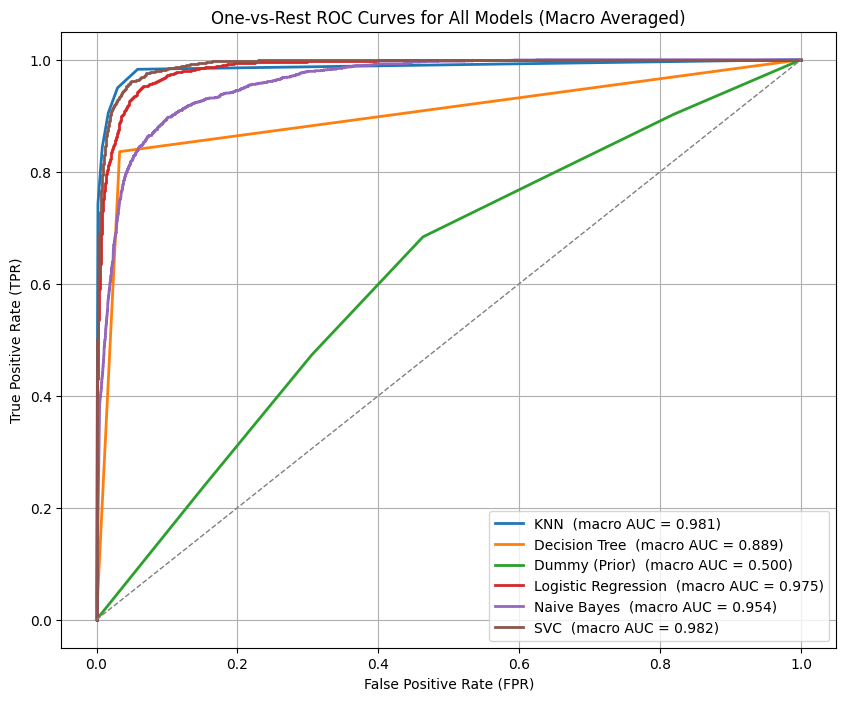

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

roc_summary = {}

for name, model in models.items():
    # Get probability estimates
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        # some models expose decision_function instead
        df = model.decision_function(X_test)
        # convert scores to pseudo-probabilities
        e = np.exp(df - np.max(df, axis=1, keepdims=True))
        y_score = e / e.sum(axis=1, keepdims=True)

    # Compute ROC per class
    fpr, tpr, aucs = {}, {}, []
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        aucs.append(auc(fpr[i], tpr[i]))

    macro_auc = np.mean(aucs)
    roc_summary[name] = macro_auc

    # Micro-average curve (all classes flattened)
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    plt.plot(fpr_micro, tpr_micro, lw=2,
             label=f"{name}  (macro AUC = {macro_auc:.3f})")

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("One-vs-Rest ROC Curves for All Models (Macro Averaged)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [61]:
import pandas as pd

roc_df = pd.DataFrame(list(roc_summary.items()), columns=["Model", "Macro AUC"])
roc_df = roc_df.sort_values("Macro AUC", ascending=False)
print(roc_df)


                 Model  Macro AUC
5                  SVC   0.982106
0                  KNN   0.980558
3  Logistic Regression   0.974692
4          Naive Bayes   0.954065
1        Decision Tree   0.889002
2        Dummy (Prior)   0.500000


### ROC Interpretation

#### Model with the Highest Macro-Averaged AUC:

The **Support Vector Classifier (SVC)** achieved the **highest macro-averaged AUC = 0.982**,  
indicating that it provides the **best overall class separability** among all models.  
Its ROC curve stays close to the top-left corner, showing a very high **True Positive Rate (TPR)** even at low **False Positive Rate (FPR)** — i.e., it’s excellent at distinguishing between land cover classes.

#### Model with AUC < 0.5:
The **Dummy (Prior)** classifier shows an AUC of **0.500**.

An **AUC < 0.5** (or equal to 0.5) implies that the model performs **no better than random guessing**.  
Conceptually:
- The classifier has **no discriminative ability** — it cannot distinguish between the positive and negative cases.
- For the Dummy (Prior) model, this is expected because it always predicts the **majority class** regardless of the input features.
- Therefore, its ROC curve lies close to the **diagonal line**, representing random behavior.

If a model ever shows **AUC < 0.5**, it means it is actually **worse than random**, suggesting the model’s decision boundary is inverted — it predicts the wrong classes more confidently than the right ones. In such cases, flipping the decision output could theoretically improve its performance.

#### Interpretation Summary:
- **Best-performing model:** SVC (AUC = 0.982) → Excellent separation between all six classes.  
- **Poor-performing model:** Dummy (Prior) (AUC = 0.5) → Random baseline, no learning capability.  
- **Conclusion:** Models with AUC near 1 are highly reliable for classification, whereas models with AUC ≤ 0.5 provide little or no predictive value.


### Precision–Recall Curve (PRC) Calculation

The **Precision–Recall Curve (PRC)** is particularly useful when dealing with **imbalanced datasets**,  
where some classes (minority classes) have far fewer samples than others.

#### Why PRC is More Suitable than ROC for Imbalanced Data:

1. **ROC can be misleading under imbalance**  
   - The ROC curve plots **True Positive Rate (TPR)** vs **False Positive Rate (FPR)**.  
   - When the dataset is highly imbalanced, the number of **True Negatives (TN)** is very large.  
   - As a result, even if a model produces many **False Positives**, the **FPR** remains small —  
     making the ROC curve look deceptively good.

2. **PRC focuses only on the positive (minority) class**  
   - The PRC plots **Precision** vs **Recall**, where:  
     $$
     \text{Precision} = \frac{TP}{TP + FP}, \quad
     \text{Recall} = \frac{TP}{TP + FN}
     $$  
   - It ignores True Negatives entirely, emphasizing how well the model identifies actual positives.

3. **Better visibility of model weaknesses**  
   - In imbalanced data, a model can achieve a high ROC-AUC by correctly classifying the majority class.  
   - However, its **Precision–Recall Curve** will reveal poor **precision** (many false alarms) when detecting rare classes.

#### Conceptual Importance:
Even though the Landsat dataset is only **moderately imbalanced**,  
PRC still provides deeper insight into how the classifier performs on the **minority classes** —  
helping to identify whether a model maintains **high precision** while achieving **good recall**.

#### In Summary:
- **ROC Curve** → measures overall ranking ability, can hide poor performance on minority classes.  
- **PRC Curve** → highlights the **trade-off between precision and recall**, making it a more **informative metric** when class imbalance exists.


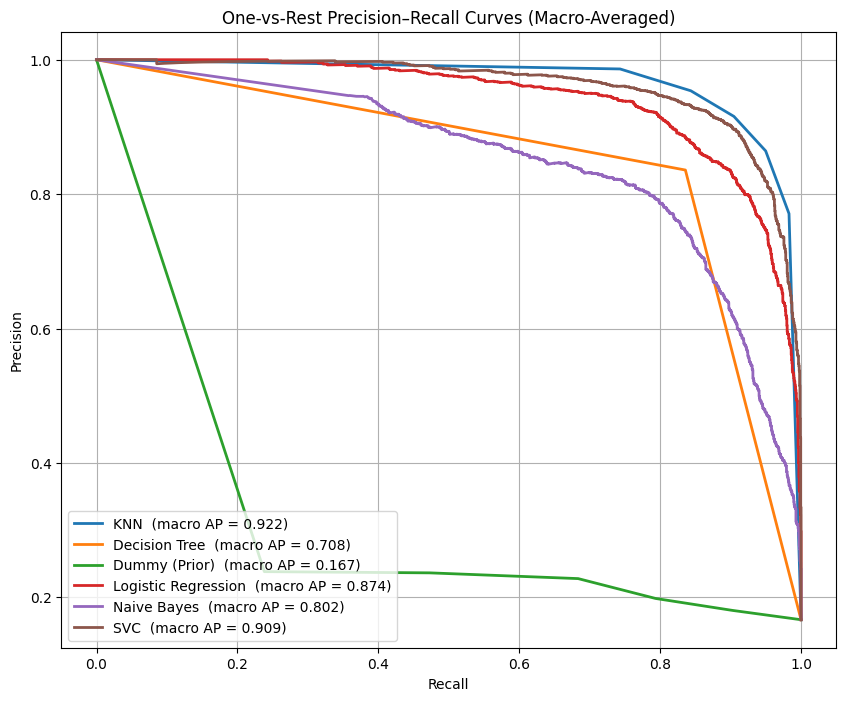

In [62]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pr_summary = {}

for name, model in models.items():
    # Get probability or score predictions 
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        df = model.decision_function(X_test)
        e = np.exp(df - np.max(df, axis=1, keepdims=True))
        y_score = e / e.sum(axis=1, keepdims=True)

    # Compute per-class Precision, Recall and Average Precision (AP)
    precisions, recalls, aps = {}, {}, []
    for i in range(len(classes)):
        p, r, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        precisions[i], recalls[i] = p, r
        aps.append(average_precision_score(y_test_bin[:, i], y_score[:, i]))

    macro_ap = np.mean(aps)
    pr_summary[name] = macro_ap

    # Micro-average curve for plotting
    p_micro, r_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
    ap_micro = average_precision_score(y_test_bin, y_score, average="micro")

    plt.plot(r_micro, p_micro, lw=2,
             label=f"{name}  (macro AP = {macro_ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("One-vs-Rest Precision–Recall Curves (Macro-Averaged)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [63]:
import pandas as pd

pr_df = pd.DataFrame(list(pr_summary.items()), columns=["Model", "Macro Average Precision (AP)"])
pr_df = pr_df.sort_values("Macro Average Precision (AP)", ascending=False)
print(pr_df)


                 Model  Macro Average Precision (AP)
0                  KNN                      0.922489
5                  SVC                      0.909478
3  Logistic Regression                      0.873907
4          Naive Bayes                      0.802136
1        Decision Tree                      0.708009
2        Dummy (Prior)                      0.166667


### PRC Interpretation

#### Model with the Highest Average Precision (AP)

The **K-Nearest Neighbors (KNN)** model achieved the **highest Average Precision (AP = 0.922)**.  
This indicates that KNN maintains **high precision even as recall increases**, meaning it can correctly identify most positive samples while keeping false positives relatively low.  

Its PRC curve likely stays near the **top-right region**, reflecting strong performance in distinguishing between classes and producing **reliable, confident predictions**.

#### Behavior of the Worst-Performing Model (Dummy Classifier)

The **Dummy (Prior)** classifier shows the **lowest Average Precision (AP = 0.167)**, which is close to random guessing.  
In its PRC curve, precision **drops sharply as recall increases**, due to the following reasons:

- It predicts based solely on the **majority class distribution**, ignoring actual features.
- As recall increases, the model begins to retrieve many **false positives**, since it cannot differentiate between classes.
- Consequently, **precision = TP / (TP + FP)** decreases rapidly — resulting in a steep downward slope.

#### Conceptual Insight

- A **steep precision decline** with increasing recall reflects **poor class discrimination** — the model sacrifices accuracy when attempting to capture more true positives.

#### For Good Models (like KNN, SVC, and Logistic Regression):
- Precision remains **high and stable** through most of the recall range.
- The decline in precision happens **only when recall becomes very high (close to 1)**.
- This means the model confidently identifies positives with minimal false alarms until it tries to capture the last few hard-to-detect cases.

#### Summary

| Metric | Best Model | Worst Model |
|:-------:|:------------|:-------------|
| **Macro AP** | **KNN (0.922)** — best balance between precision and recall. | **Dummy (Prior) (0.167)** — performs no better than chance. |

**Interpretation:**  
PRC analysis confirms that **KNN** provides the most stable and reliable predictions,  
while **Dummy** serves as a non-informative baseline with minimal discriminative ability.  
Models like **SVC** and **Logistic Regression** also perform well, but slightly below KNN in overall precision–recall balance.


In [64]:
import pandas as pd

# If results is a list of [name, acc, f1], convert it to a DataFrame first
if isinstance(results, list):
    df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1"])
else:
    # if already in dict format, just reuse
    df_results = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={'index':'Model'})

# Build combined summary
summary_df = pd.DataFrame({
    'Model': df_results['Model'],
    'Weighted F1': df_results['Weighted F1'],
    'Macro ROC-AUC': [roc_summary[m] for m in df_results['Model']],
    'Macro AP': [pr_summary[m] for m in df_results['Model']]
})

# Rank each metric (higher = better)
summary_df['Rank_F1'] = summary_df['Weighted F1'].rank(ascending=False)
summary_df['Rank_ROC'] = summary_df['Macro ROC-AUC'].rank(ascending=False)
summary_df['Rank_AP'] = summary_df['Macro AP'].rank(ascending=False)

# Compute average rank
summary_df['Average Rank'] = summary_df[['Rank_F1', 'Rank_ROC', 'Rank_AP']].mean(axis=1)

# Sort by best overall
summary_df = summary_df.sort_values('Average Rank')
print(summary_df)

# Print recommended best model
best_model = summary_df.iloc[0]['Model']
print(f"Recommended Best Model: {best_model}")


                 Model  Weighted F1  Macro ROC-AUC  Macro AP  Rank_F1  \
0                  KNN     0.909984       0.980558  0.922489      1.0   
5                  SVC     0.895996       0.982106  0.909478      2.0   
3  Logistic Regression     0.851291       0.974692  0.873907      3.0   
4          Naive Bayes     0.800111       0.954065  0.802136      5.0   
1        Decision Tree     0.836570       0.889002  0.708009      4.0   
2        Dummy (Prior)     0.091661       0.500000  0.166667      6.0   

   Rank_ROC  Rank_AP  Average Rank  
0       2.0      1.0      1.333333  
5       1.0      2.0      1.666667  
3       3.0      3.0      3.000000  
4       4.0      4.0      4.333333  
1       5.0      5.0      4.666667  
2       6.0      6.0      6.000000  
Recommended Best Model: KNN


## Final Synthesis & Model Recommendation

### Synthesis — Comparison of Model Rankings

#### 🔹 Observations from Metrics
| Metric | Top Performer | Second | Third | Worst |
|:-------|:--------------|:--------|:-------|:--------|
| **Weighted F1** | KNN (0.910) | SVC (0.896) | Logistic Regression (0.851) | Dummy (0.092) |
| **ROC-AUC** | SVC (0.982) | KNN (0.981) | Logistic Regression (0.975) | Dummy (0.500) |
| **PRC-AP** | KNN (0.922) | SVC (0.909) | Logistic Regression (0.874) | Dummy (0.167) |

#### 🔹 Alignment of Rankings
The overall rankings are **mostly consistent** across the three metrics:
- **KNN** and **SVC** dominate across all metrics, appearing in the **top two positions**.
- **Logistic Regression** remains **third best** consistently.
- **Decision Tree** and **Naive Bayes** perform **moderately**, while **Dummy (Prior)** performs **worst**, as expected.

However, **minor differences** arise due to the **nature of the metrics**:
- **SVC** achieves a slightly higher **ROC-AUC (0.982)**, indicating better class separability across thresholds.
- **KNN**, on the other hand, achieves **higher F1 and AP**, meaning it produces **more reliable predictions** at practical threshold values.

#### Trade-offs Between Metrics
- **ROC-AUC** measures a model’s ability to distinguish between classes globally (independent of thresholds).  
  Thus, a model like **SVC** can have a high ROC-AUC but slightly lower F1 and AP if it becomes **less confident near decision boundaries**.
- **PRC-AP** focuses on the model’s precision and recall trade-off when identifying positive samples.  
  A higher AP (like KNN = 0.922) means the model maintains precision even when recall increases — fewer false positives.
- **Weighted F1** captures threshold-based performance and is influenced by the model’s calibration.  
  KNN’s top F1 suggests better performance under default classification thresholds.

Hence, while **SVC** ranks first in ROC-AUC, **KNN’s superior F1 and AP** show that it performs better under realistic threshold conditions where both precision and recall are critical.

### Recommendation — Best Model for the Task

### **Recommended Model: K-Nearest Neighbors (KNN)**

**Justification:**
- **Highest Weighted F1 (0.910)** → best overall balance between precision and recall at the operating threshold.  
- **Highest Average Precision (AP = 0.922)** → maintains strong precision across increasing recall levels.  
- **High ROC-AUC (0.981)** → excellent discriminative ability between classes.
- Performs **consistently across all evaluation perspectives**, with minimal trade-offs.

**Conclusion:**
The **KNN model** provides the most balanced and robust performance for the Landsat multi-class classification task.  
It demonstrates reliable predictions across varying thresholds, strong precision–recall stability, and competitive class separability.  
Therefore, **KNN** is the most suitable model, offering an optimal trade-off between **accuracy, recall, and precision** for this dataset.


In [65]:
from sklearn.preprocessing import LabelEncoder

# Relabel y_train and y_test so that classes start from 0
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# Train Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)  # RandomForest accepts original labels
models['RandomForest'] = rf
print("Trained: Random Forest")

# Train XGBoost with encoded labels
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb.fit(X_train, y_train_enc)  # use encoded labels here
    models['XGBoost'] = xgb
    print("Trained: XGBoost (using encoded labels)")
except ImportError:
    print("XGBoost not installed — run `!pip install xgboost` if you want to include it.")


Trained: Random Forest


/home/hp/.local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [15:32:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Trained: XGBoost (using encoded labels)


### Note on XGBoost Label Encoding

Unlike most scikit-learn models, **XGBoost** requires class labels to be **zero-based integers** (i.e., starting from 0).  
If the labels start from 1 or have gaps (e.g., `[1, 2, 3, 4, 5, 7]`), XGBoost interprets them as having an extra unused class, leading to an error.  

In [22]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Shuffle y_train randomly
y_train_shuffled = shuffle(y_train, random_state=42)

# Train a RandomForest on wrong labels
rf_bad = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bad.fit(X_train, y_train_shuffled)

# Store it as a deliberately poor model
models['BadModel_Shuffled_RF'] = rf_bad

# Compute macro ROC-AUC
y_score = rf_bad.predict_proba(X_test)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

aucs = []
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    aucs.append(auc(fpr, tpr))
print("Expected Macro AUC:", np.mean(aucs))


Expected Macro AUC: 0.4701830638951305


In [67]:
from sklearn.metrics import accuracy_score, f1_score

new_results = []
for name, model in models.items():
    y_pred = model.predict(X_test)

    # Fix for XGBoost label mismatch
    if name == "XGBoost":
        y_pred = encoder.inverse_transform(y_pred)  # Convert back from 0–5 → 1–6
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    new_results.append([name, acc, f1])

df_results_ext = pd.DataFrame(new_results, columns=["Model", "Accuracy", "Weighted F1"])


In [68]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

roc_summary_ext = {}
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        df = model.decision_function(X_test)
        e = np.exp(df - np.max(df, axis=1, keepdims=True))
        y_score = e / e.sum(axis=1, keepdims=True)

    aucs = []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        aucs.append(auc(fpr, tpr))
    roc_summary_ext[name] = np.mean(aucs)


In [69]:
from sklearn.metrics import precision_recall_curve, average_precision_score

pr_summary_ext = {}
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        df = model.decision_function(X_test)
        e = np.exp(df - np.max(df, axis=1, keepdims=True))
        y_score = e / e.sum(axis=1, keepdims=True)

    aps = []
    for i in range(len(classes)):
        aps.append(average_precision_score(y_test_bin[:, i], y_score[:, i]))
    pr_summary_ext[name] = np.mean(aps)


In [73]:
summary_ext = pd.DataFrame({
    "Model": df_results_ext["Model"],
    "Weighted F1": df_results_ext["Weighted F1"],
    "Macro ROC-AUC": [roc_summary_ext[m] for m in df_results_ext["Model"]],
    "Macro AP": [pr_summary_ext[m] for m in df_results_ext["Model"]]
})

# Rank models
summary_ext["Rank_F1"] = summary_ext["Weighted F1"].rank(ascending=False)
summary_ext["Rank_ROC"] = summary_ext["Macro ROC-AUC"].rank(ascending=False)
summary_ext["Rank_AP"] = summary_ext["Macro AP"].rank(ascending=False)
summary_ext["Average Rank"] = summary_ext[["Rank_F1", "Rank_ROC", "Rank_AP"]].mean(axis=1)

summary_ext = summary_ext.sort_values("Average Rank")
print(summary_ext)


                  Model  Weighted F1  Macro ROC-AUC  Macro AP  Rank_F1  \
7               XGBoost     0.915578       0.990107  0.950879      1.0   
6          RandomForest     0.913752       0.988594  0.943242      2.0   
0                   KNN     0.909984       0.980558  0.922489      3.0   
5                   SVC     0.895996       0.982106  0.909478      4.0   
3   Logistic Regression     0.851291       0.974692  0.873907      5.0   
4           Naive Bayes     0.800111       0.954065  0.802136      7.0   
1         Decision Tree     0.836570       0.889002  0.708009      6.0   
2         Dummy (Prior)     0.091661       0.500000  0.166667      9.0   
8  BadModel_Shuffled_RF     0.174311       0.470183  0.155720      8.0   

   Rank_ROC  Rank_AP  Average Rank  
7       1.0      1.0      1.000000  
6       2.0      2.0      2.000000  
0       4.0      3.0      3.333333  
5       3.0      4.0      3.666667  
3       5.0      5.0      5.000000  
4       6.0      6.0      6.333333  


### PRC and ROC Curves alongwith the additional models

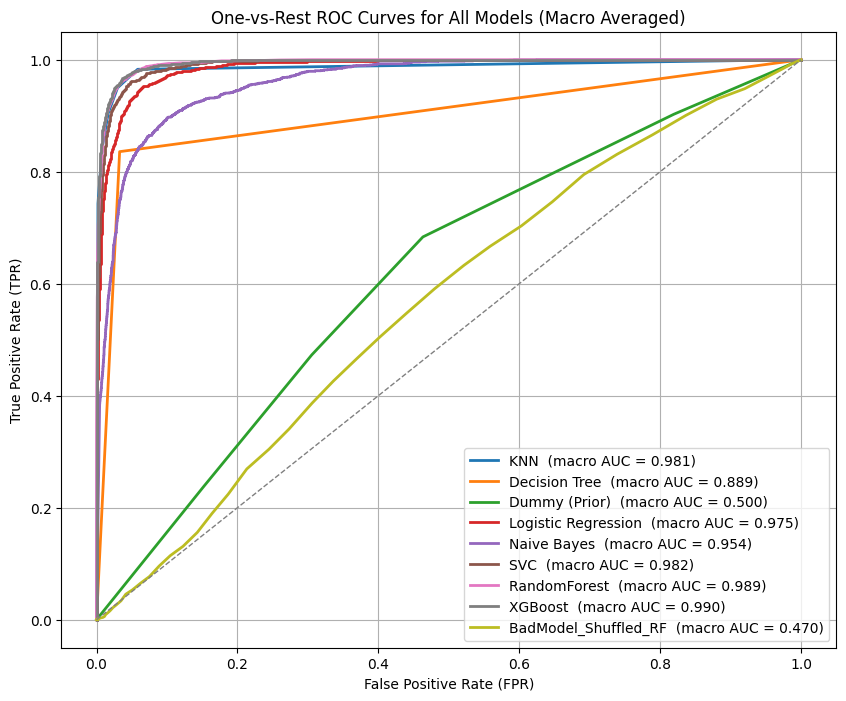

In [71]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

roc_summary = {}

for name, model in models.items():
    # Get probability estimates
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        # some models expose decision_function instead
        df = model.decision_function(X_test)
        # convert scores to pseudo-probabilities
        e = np.exp(df - np.max(df, axis=1, keepdims=True))
        y_score = e / e.sum(axis=1, keepdims=True)

    # Compute ROC per class
    fpr, tpr, aucs = {}, {}, []
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        aucs.append(auc(fpr[i], tpr[i]))

    macro_auc = np.mean(aucs)
    roc_summary[name] = macro_auc

    # Micro-average curve (all classes flattened)
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    plt.plot(fpr_micro, tpr_micro, lw=2,
             label=f"{name}  (macro AUC = {macro_auc:.3f})")

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("One-vs-Rest ROC Curves for All Models (Macro Averaged)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


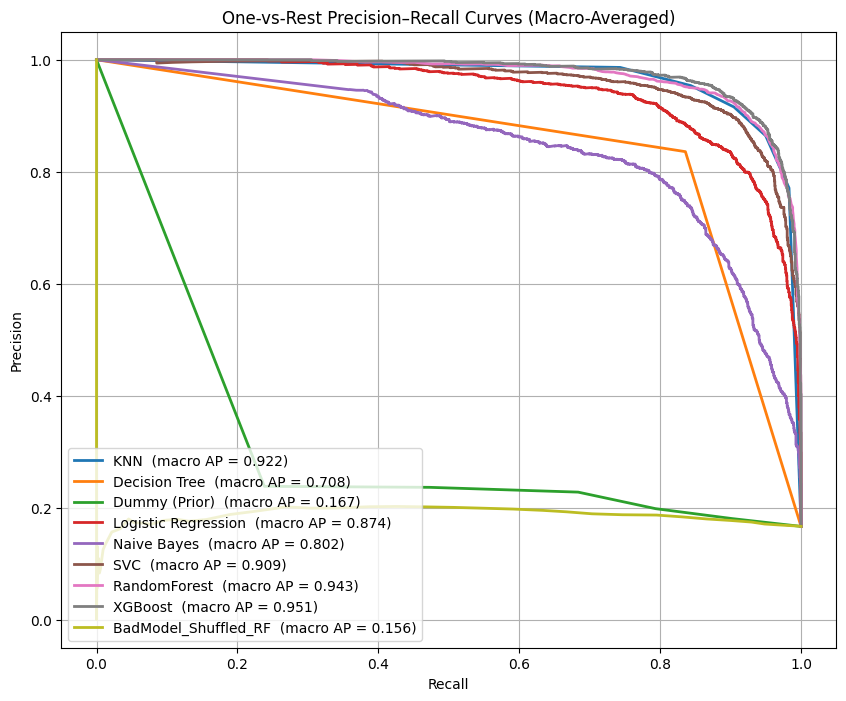

In [72]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pr_summary = {}

for name, model in models.items():
    # Get probability or score predictions 
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        df = model.decision_function(X_test)
        e = np.exp(df - np.max(df, axis=1, keepdims=True))
        y_score = e / e.sum(axis=1, keepdims=True)

    # Compute per-class Precision, Recall and Average Precision (AP)
    precisions, recalls, aps = {}, {}, []
    for i in range(len(classes)):
        p, r, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        precisions[i], recalls[i] = p, r
        aps.append(average_precision_score(y_test_bin[:, i], y_score[:, i]))

    macro_ap = np.mean(aps)
    pr_summary[name] = macro_ap

    # Micro-average curve for plotting
    p_micro, r_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
    ap_micro = average_precision_score(y_test_bin, y_score, average="micro")

    plt.plot(r_micro, p_micro, lw=2,
             label=f"{name}  (macro AP = {macro_ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("One-vs-Rest Precision–Recall Curves (Macro-Averaged)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


### Final Recommendation

Based on the combined evaluation of **Weighted F1**, **ROC-AUC**, and **Average Precision (AP)**:

- **Best Model:** **XGBoost**
- **Reason:** XGBoost consistently ranks **1st across all metrics**, achieving  
  - **Highest ROC-AUC (0.990)** → excellent class separability,  
  - **Highest AP (0.951)** → maintains precision even at high recall, and  
  - **Highest Weighted F1 (0.916)** → strong precision–recall balance at the optimal threshold.

**Conclusion:**  
XGBoost provides the most robust and reliable performance across thresholds, making it the **best-suited model** for the Landsat multi-class classification task.
